In [13]:
import trsfile
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../src/utils')
import aes
import constants
sys.path.insert(0, '../../src/modeling')
from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [26]:
# First test: 
    # - only one trace file
    # - assume generator only for train and val
    # - pass the train and val indices to the generator


class CustomDataGenerator(Sequence):
    
    def __init__(self, tr_file, tr_indices, batch_size, target, n_classes, byte_idx, to_fit=True, shuffle_on_epoch_end=True):
        self.tr_file = tr_file
        self.tr_indices = tr_indices
        self.batch_size = batch_size
        self.target = target
        self.n_classes = n_classes
        self.byte_idx = byte_idx
        self.to_fit = to_fit
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        
        self.on_epoch_end()
        
        
    def __len__(self):
        # Generates the number of batches per epoch
        return int(np.floor(len(self.tr_indices) / self.batch_size))
        
        
    def __getitem__(self, index):
        # Generates a batch of data
        i = index * self.batch_size
        batch_indices = self.tr_indices[i : i + self.batch_size]
        
        x, y = self._read_traces(batch_indices)
        
        if self.to_fit:
            return x, y
        else:
            return x
    
    
    def on_epoch_end(self):
        # Eventually shuffles the order of the traces
        if self.shuffle_on_epoch_end:
            np.random.shuffle(list(self.tr_indices))
    
    
    def _read_traces(self, batch_indices):
        # Reads the traces from file
        x = []
        y = []
        
        with trsfile.open(self.tr_file, 'r') as traces:
            batch_traces = [traces[i] for i in batch_indices]
            for tr in batch_traces:
                s = tr.samples
                l = self._retrieve_label(tr)
                
                x.append(s)
                y.append(l)
                
        x = np.array(x)
        y = np.array(y)
        
        return x, y
        
        
    def _retrieve_label(self, tr):
        # Retrieves the label associated to the given trace
        p = np.array(tr.get_input())
        k = np.array(tr.get_key())
        l = aes.labels_from_key(p, k, self.target)
        l = l[self.byte_idx]
        
        l = to_categorical(l, self.n_classes)
        
        return l

In [20]:
TOT_TRACES = 50000

# tr_file = f'{constants.MSK_PC_TRACES_PATH}/D3-K7_round1_500MHz + Resampled.trs'
tr_file = f'{constants.PC_TRACES_PATH}/D3-K7_500MHz + Resampled.trs'
train_split = int(TOT_TRACES * 0.9)
train_indices = range(TOT_TRACES)[:train_split]
val_indices = range(TOT_TRACES)[train_split:]
target = 'SBOX_OUT'
n_classes = 256
byte_idx = 0

In [21]:
# # Original HPs b0 1dev
hp = {
    "hidden_layers": 4, 
    "hidden_neurons": 400, 
    "dropout_rate": 0.2, 
    "l2": 0.0, 
    "optimizer": "adam", 
    "learning_rate": 0.001, 
    "batch_size": 256
}

In [22]:
train_gen = CustomDataGenerator(
    tr_file,
    train_indices,
    hp['batch_size'],
    target,
    n_classes,
    byte_idx
)

val_gen = CustomDataGenerator(
    tr_file,
    val_indices,
    hp['batch_size'],
    target,
    n_classes,
    byte_idx
)

In [44]:
# Train and save the model
net = Network('MLP', hp)
net.build_model()

history = net.model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=100,
    callbacks=net.callbacks,
    verbose=1
).history

Epoch 1/100
175/175 [==============================] - 4s 17ms/step - loss: 5.1744 - accuracy: 0.0213 - val_loss: 6.9996 - val_accuracy: 0.0179 - lr: 0.0010
Epoch 2/100
175/175 [==============================] - 3s 16ms/step - loss: 4.1938 - accuracy: 0.0696 - val_loss: 7.1485 - val_accuracy: 0.0169 - lr: 0.0010
Epoch 3/100
175/175 [==============================] - 3s 16ms/step - loss: 3.8438 - accuracy: 0.0949 - val_loss: 6.8189 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 4/100
175/175 [==============================] - 3s 16ms/step - loss: 3.6712 - accuracy: 0.1114 - val_loss: 6.5343 - val_accuracy: 0.0199 - lr: 0.0010
Epoch 5/100
175/175 [==============================] - 3s 15ms/step - loss: 3.5539 - accuracy: 0.1223 - val_loss: 7.0162 - val_accuracy: 0.0214 - lr: 0.0010
Epoch 6/100
175/175 [==============================] - 3s 16ms/step - loss: 3.4643 - accuracy: 0.1308 - val_loss: 3.4900 - val_accuracy: 0.1299 - lr: 0.0010
Epoch 7/100
175/175 [==============================] - 3s 

In [45]:
def plot_history(history, metric):
    
    """
    Plots the training history (train_loss vs val_loss, train_acc vs val_acc).
    
    Parameters:
        - history (dict):
            Train history.
        - metric (str):
            Metric to plot.
        - output_path (str):
            Absolute path to the PNG file containing the plot.
    """
    
    f = plt.figure(figsize=(10,10))

    train_label = f'train_{metric}'
    val_label = f'val_{metric}'
    title = f'Train and Val {metric.title()}' # .title() upper-cases only the first letter
    
    plt.plot(history[metric], label=train_label)
    plt.plot(history[val_label], label=val_label)
    plt.title(title)
    plt.ylabel(metric.title())
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    
    plt.show()
    
    plt.close(f)

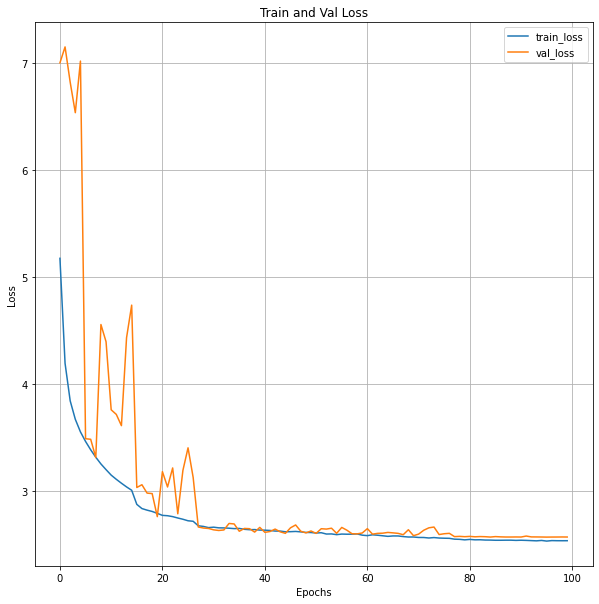

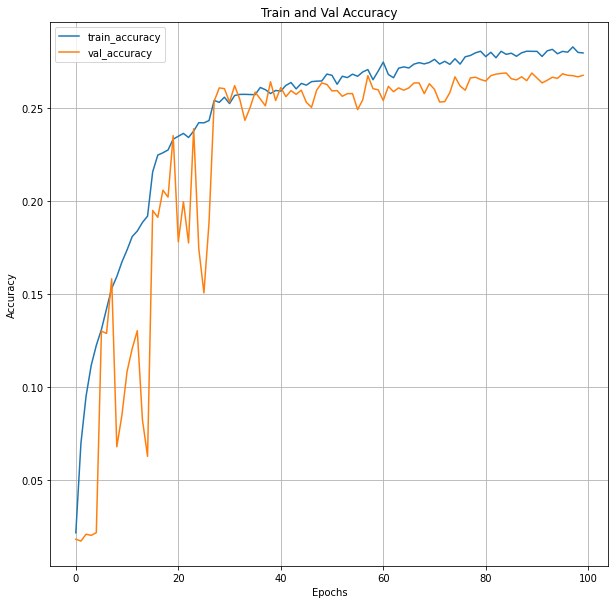

In [46]:
plot_history(history, 'loss')
plot_history(history, 'accuracy')

In [47]:
EVAL_TRACES = 50000

# tr_file = f'{constants.MSK_PC_TRACES_PATH}/D3-K7_round1_500MHz + Resampled.trs'
eval_file = f'{constants.PC_TRACES_PATH}/D2-K0_500MHz + Resampled.trs'
eval_indices = range(EVAL_TRACES)

In [48]:
eval_gen = CustomDataGenerator(
    tr_file,
    eval_indices,
    hp['batch_size'],
    target,
    n_classes,
    byte_idx
)

In [49]:
attack_loss, attack_acc = net.model.evaluate(eval_gen, verbose=1)

print(f'Attack Loss:     {attack_loss:.2f}')
print(f'Attack Accuracy: {(attack_acc*100):.2f}%')

195/195 [==============================] - 3s 14ms/step - loss: 4.2366 - accuracy: 0.1299
Attack Loss:     4.24
Attack Accuracy: 12.99%


# CONSIDERATIONS

## New CustomDataGenerator used to get more traces for training without OOM
## Single dev seems to have good performance in portability scenarios (13%)
## Double dev seems not to enhance performance
## Trying to extend CustomDataGenerator with multiple files efficiently

In [99]:
from contextlib import ExitStack
from tqdm import tqdm

N_KEYS = 10

trace_files = [f'{constants.PC_TRACES_PATH}/D1-{k}_500MHz + Resampled.trs' 
               for k in list(constants.KEYS)[1:N_KEYS+1]]

with ExitStack() as stack:
    
    tracesets = [stack.enter_context(trsfile.open(tr_file, 'r')) for tr_file in trace_files]
    
    count = 0
    samples = []
    plaintexts = []
    keys = []
    for x in tqdm(zip(*tracesets)):
        if count < 5000:
            samples.append([el.samples for el in x])
            plaintexts.append([el.get_input() for el in x])
            keys.append([el.get_key() for el in x])
            count += 1
        else:
            break
    
    samples = np.vstack(samples)
    plaintexts = np.vstack(plaintexts)
    keys = np.vstack(keys)

5000it [00:00, 6563.16it/s]


In [100]:
samples.shape

(50000, 1183)

In [101]:
plaintexts.shape

(50000, 16)

In [104]:
keys.shape

(50000, 16)